In [1]:
import numpy as np
from functools import partial
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit, vectorize, float64, int64
import stahmctestt as stt #our package
%matplotlib inline

## Analysis on simulated logistic regression

In [61]:
#define the gradient function for logistic regression
#derivation refer to hdeg.ipynb
@jit(cache=True)
def gradlogistic(theta,X,y):  
    """
    theta:p.1-1d array
    X:n.p-2d array
    y n.1-1d array"""
    drll=np.diag(y-1/(1+np.exp(-X@theta)))@X
    drpri=-np.linalg.solve(np.diag([16,16,16,16,16]),theta)
    return -drpri,-drll.mean(axis=0)

In [62]:
###simulate data
def sim_log(m,n,theta):
    """This function outputs a simulated logistics regression dataset X and y. 
       X is a matrix of size m by n. Every entry of X is i.i.d N(0,1).
    Args:
        m: the number of rows in X
        n: the number of columns in X
        beta: a n by 1 vector, the true beta in the model
    """
    X=np.random.normal(loc=0,scale=1,size=[m,n])
    y=np.random.binomial(n=1,p=1/(1+np.exp(-(X @ theta))))
    return X,y

In [67]:
#split data into training and testing
theta=np.array([2,10,-5,0,0])
X,y=sim_log(20000,5,theta)
testidx=np.random.choice(range(20000),10000,replace=False)
trainidx=np.array(list(set(range(20000))-set(testidx)))
X_train=X[trainidx,:]
y_train=y[trainidx]
X_test=X[testidx,:]
y_test=y[testidx]

In [68]:
#the posterior sampler using sgld 
@jit([float64[:,:](float64[:,:],float64[:],float64[:],float64[:,:],float64[:,:],float64, int64,int64)],cache=True)
def sgld_nbvec(X,y,theta0,M,C,epsilon,batchsize=50,iter=1000):
    """
    This function outputs the p dimiension Hamilton Monte Carlo samples without M-H correction.    
    Args: 
        X:n.p-2d array
        y n.1-1d array
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        batchsize: the number of minibatch used
        iter: iteration number, 1000 by default
    """
    n=y.size
    T=X.shape[0]
    p=theta0.shape[0]
    theta=theta0
    theta_save=np.zeros([iter,p])
    for t in range(iter):    
        batch=np.random.choice(n,batchsize,replace=False)
        pr,ll=gradlogistic(theta,X[batch,:],y[batch])
        theta=theta-(pr+T*ll)*epsilon+np.random.multivariate_normal(np.zeros(p),2*epsilon*np.identity(p),1).ravel()
        theta_save[t,:]=theta
    return theta_save

In [69]:
#the posterior sampler using sg HMC without M-H
@jit([float64[:,:](float64[:,:],float64[:],float64[:],float64[:,:],float64[:,:],float64, int64,int64)],cache=True)
def sgd_nbvec(X,y,theta0,M,C,epsilon,batchsize=50,iter=1000):
    """
    This function outputs the p dimiension Hamilton Monte Carlo samples without M-H correction.    
    Args: 
        X:n.p-2d array
        y n.1-1d array
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        batchsize: the number of minibatch used
        iter: iteration number, 1000 by default
    """
    n=y.size
    p=theta0.shape[0]
    T=X.shape[0]
    r=np.random.multivariate_normal(np.zeros(p),M)
    theta=theta0
    theta_save=np.zeros([iter,p])
    r_save=np.zeros([iter,p])
    for t in range(iter):
        r=np.random.multivariate_normal(np.zeros(p),M)
        for i in range(10):
            mr=np.linalg.solve(M,r)
            theta=theta+epsilon*mr
            batch=np.random.choice(n,batchsize,replace=False)
            pr,ll=gradlogistic(theta,X[batch,:],y[batch])
            r=r-(pr+T*ll)*epsilon
        theta_save[t,:]=theta
        r_save[t,:]=r
    return theta_save

In [71]:
#draw posterior from three methods
theta0=np.zeros(5)
M=C=np.identity(5)
epsilon=.001
size=100
out_sghmc=stt.hmc_nbvec(gradlogistic,X_train,y_train,theta0,M,C,epsilon,size,iter=5000)[:,:5]
out_sgld=sgld_nbvec(X_train,y_train,theta0,M,C,epsilon,size,iter=5000)
out_sgd=sgd_nbvec(X,y,theta0,M,C,epsilon,size,iter=5000)

In [59]:
#use posterior predictive for prediction
def gen_testplot(out_sghmc,out_sgld,out_sgd,y_test,points=[100,200,300,400,500,800,1000,1500,2000,2500,3000,3500,4500,5000]):
     """This function plots test error vs iteration number using the outputs of samplers    
    Args:
        out_sghmc: the output of SGHMC sampler
        out_sgld: the output of SGLD sampler
        X_test: the X of the test set
        y_test: the y of the test set
        points: the points to record test error
        """
    sghmcerr=[1-np.mean(np.random.binomial(n=1,p=1/(1+np.exp(-(X_test @ out_sghmc[:point,:].T))))==y_test[:,None]) for point in points]
    sglderr=[1-np.mean(np.random.binomial(n=1,p=1/(1+np.exp(-(X_test @ out_sgld[:point,:].T))))==y_test[:,None]) for point in points]
    sgderr=[1-np.mean(np.random.binomial(n=1,p=1/(1+np.exp(-(X_test @ out_sgd[:point,:].T))))==y_test[:,None]) for point in points]
    plt.plot(points,sghmcerr)
    plt.plot(points,sglderr)
    plt.plot(points,sgderr)
    plt.legend(['sghmc','sgld','hmc without M-H'])
    plt.title('Test Error vs Iteration Number')
    plt.ylabel('Test Error')
    plt.xlabel('Iteration Number')
    pass

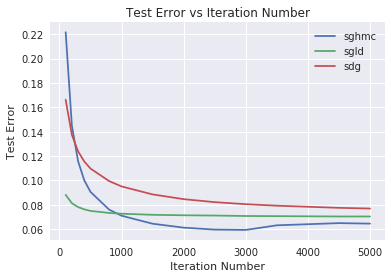

In [72]:
gen_testplot(out_sghmc,out_sgld,out_sgd,y_test)